# Model notebook

This notebook serves as an all-in-one file to train a convolutional neural network, use the network for a prediction and evaluate the result.

After importing all necessary packages and functions there is a **Settings** cell, where the user can set all necessary inputs and parameters. This includes choosing a **execute mode**, where the user selects if they either want to train a model, use a saved model for prediction or use the saved results of a prediction to evaluate the model:

| Execute mode | trains model | predicts labels | evaluates prediction | input needed |
| ----------- | ----------- | ----------- | ----------- | ----------- |
| 0 | yes | yes | yes | None |
| 1 | no | yes | yes | model.pth |
| 2 | no | no | yes | model.pth, parameters.csv, train_loss.csv, val_loss.csv, eval_preds_df.csv, submission_df.csv |

In [1]:
%matplotlib inline

# We have outsourced most of the necessary functions we have written and all packages we need to import for this notebook into a functions.py file.
from functions import *

# Settings

There are a few key settings the notebook needs the user to set:

* `data_folder`: should contain the image files.
* `execute_mode`: see above for the description.
* `create_submission`: If we want to create a submission csv for the DrivenData challenge, we set this to `True`.
* `model_folder`: if we use execute_mode `1` or `2`, this folder should contain the files mentioned in the table above.
* `param section`: Set parameters here for training the model or making a prediction.

If the `data_folder` already exists, you will be prompted to type `d` and hit `Enter` if you want to overwrite the folder, or `r` and `Enter` if you want to save the the output in another folder.

In [2]:
data_folder = '../data' # ! if this notebook and folders "train_features" and "test_features" are in the same folder use '.'

# execute_mode: see options in the table above
execute_mode = 0

# create submission: Set to True if you want to predict labels of the test set of the DrivenData competion and create/save a csv file in the submission format.
create_submission = True

# This is the folder we use to either save to or read from: our model and other files apart from the image data.
model_folder = '../models/ResNet50retrained'

# This part will either create a param dictionary with all the settings (execute_mode 0) or load the parameters from model_folder/parameters.csv
if execute_mode == 2:

    param_path = os.path.join(model_folder, 'parameters.csv')
    df_param = load_csv_if_exists(param_path)
    df_param.set_index('parameter', inplace=True)
    df_param['value'] = df_param['value'].apply(convert_value)
    param = df_param.to_dict()['value']

else:
    if execute_mode == 1:
        saved_model_file = os.path.join(model_folder, 'model.pth')       # ! check this file path if execute_mode == 1
    
    ### This function is still weird and should have three options: "replace", "create new folder for the new settings" or "cancel". Also for some reason the parameters are not saved if I create a new folder.
    handle_model_folder(model_folder)   # if this folder already exists you can chose "d" to delete it and create new or "r" to rename old folder and create new

    param = {}

    param['frac'] = 1.0             # ! part of dataset for testing (1 is the whole dataset)
    param['random_state'] = 42      # ! for part of dataset and train_test_split
    param['test_size'] = 0.25       # ! for train_test_split
    param['epochs_number'] = 10     # ! for the model
    param['batch_size'] = 32


    param['use_white_line_cropping'] = True         # ! removes 16 pixels at the bottom if its white
    param['use_logo_cropping'] = True               # ! removes the orange logo in the bottom left corner
    param['use_padding'] = False                    # ! it makes photos look square due to black borders at the top and bottom 
    param['channels_number'] = 3                    # ! 3 = real RGB, 1 = looks like black & white but in reality in rgb channel for the model


    # Convert dictionary to DataFrame with parameters as index and save to csv
    df_param = pd.DataFrame(list(param.items()), columns=['parameter', 'value']).set_index('parameter')
    df_param.to_csv(os.path.join(model_folder, 'parameters.csv'), index=True)


# Create variables and assign values
for key, value in param.items():
    globals()[key] = value
print(df_param)

New empty folder created: ../models/ResNet50retrained/
                         value
parameter                     
frac                       1.0
random_state                42
test_size                 0.25
epochs_number               10
batch_size                  32
use_white_line_cropping   True
use_logo_cropping         True
use_padding              False
channels_number              3


# Build the neural network here and define the loss criterion and optimizer

**model**:
In this template, we are loading the CNN called *ResNet50*, which comes with weights from *ImageNet* and we build a few layers on top of that.

**loss**:
Cross entropy loss (or log loss) is a commonly used loss function for multi-class (not multi-label) image classification. We'll use this to compute loss for each training batch and then update our parameters accordingly. 

**optimizer**:
The parameters for the optimizer are given to the method here. Different optimizers require different hyperparameters. Hence, we did not make them part of the `param` variable. (maybe we should?)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")   # if there is a cuda-compatible GPU ready to use, we will choose that for training and predicting, else we use the usual CPU.

if execute_mode == 0:
    model = models.resnet50(weights = 'ResNet50_Weights.IMAGENET1K_V1')
    model.fc = nn.Sequential(
        nn.Linear(2048, 100),  # dense layer takes a 2048-dim input and outputs 100-dim
        nn.ReLU(inplace=True),  # ReLU activation introduces non-linearity
        nn.Dropout(0.1),  # common technique to mitigate overfitting
        nn.Linear(
            100, 8
        ),  # final dense layer outputs 8-dim corresponding to our target classes
    )
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Check input

In this section we will preallocate some variables and also print some variables to make sure everything is loaded properly:

In [4]:
initial_train_loss = {}
initial_val_loss = {}
initial_eval_preds_df = pd.DataFrame()
initial_submission_df = pd.DataFrame()

if execute_mode == 2:
    loaded_model = torch.load(get_pth_file(model_folder))
    initial_train_loss = load_csv_if_exists(os.path.join(model_folder, 'train_loss.csv'))
    initial_train_loss = df_to_dict(initial_train_loss)
    initial_val_loss = load_csv_if_exists(os.path.join(model_folder, 'val_loss.csv'))
    initial_val_loss = df_to_dict(initial_val_loss)
    initial_eval_preds_df = load_csv_if_exists(os.path.join(model_folder, 'eval_preds_df.csv'), use_index=True)
    initial_submission_df = load_csv_if_exists(os.path.join(model_folder, 'submission_df.csv'), use_index=True)
elif execute_mode == 1:
    loaded_model = torch.load(saved_model_file)    


If the `execution_mode` is set to `0`, `intial_val_loss` should be empty, otherwise it should return the loss for the first batches of epoch 1.

In [5]:
print(initial_val_loss)

{}


Now, we load the `train_labels.csv`, `train_features.csv` and `test_features.csv`.

In [6]:
train_labels = pd.read_csv(os.path.join(data_folder, 'train_labels.csv'), index_col="id")
train_features = pd.read_csv(os.path.join(data_folder, 'train_features.csv'), index_col="id")
train_features['filepath'] = data_folder+'/'+train_features.filepath

# test_features = pd.read_csv(os.path.join(data_folder, 'test_features.csv'), index_col="id")
# test_features['filepath'] = data_folder+'/'+test_features.filepath



test_features = create_image_dataset(os.path.join(data_folder, 'test_features'))

The `features` CSVs contain the image ID, filepath and site ID for each image. 

In [7]:
train_features.head()

filepath   site
id                                                  
ZJ000000  ../data/train_features/ZJ000000.jpg  S0120
ZJ000001  ../data/train_features/ZJ000001.jpg  S0069
ZJ000002  ../data/train_features/ZJ000002.jpg  S0009
ZJ000003  ../data/train_features/ZJ000003.jpg  S0008
ZJ000004  ../data/train_features/ZJ000004.jpg  S0036

In [8]:
test_features.head()

filepath
id                                          
ZJ016488  ../data/test_features/ZJ016488.jpg
ZJ016489  ../data/test_features/ZJ016489.jpg
ZJ016490  ../data/test_features/ZJ016490.jpg
ZJ016491  ../data/test_features/ZJ016491.jpg
ZJ016492  ../data/test_features/ZJ016492.jpg

The `train_labels` CSV is an indicator matrix of the species identified in each of the training images. Some images are labeled as "blank" if no animal was detected.

In [9]:
train_labels.head()

antelope_duiker  bird  blank  civet_genet  hog  leopard   
id                                                                  
ZJ000000              0.0   1.0    0.0          0.0  0.0      0.0  \
ZJ000001              0.0   0.0    0.0          0.0  0.0      0.0   
ZJ000002              0.0   1.0    0.0          0.0  0.0      0.0   
ZJ000003              0.0   0.0    0.0          0.0  0.0      0.0   
ZJ000004              0.0   0.0    0.0          0.0  0.0      1.0   

          monkey_prosimian  rodent  
id                                  
ZJ000000               0.0     0.0  
ZJ000001               1.0     0.0  
ZJ000002               0.0     0.0  
ZJ000003               1.0     0.0  
ZJ000004               0.0     0.0

Let's store a sorted list of the labels, so that we can sort the inputs and outputs to our model in a consistent way.

In [10]:
species_labels = sorted(train_labels.columns.unique())
species_labels

['antelope_duiker',
 'bird',
 'blank',
 'civet_genet',
 'hog',
 'leopard',
 'monkey_prosimian',
 'rodent']

## 3. Explore the data

Now let's see what some of the actual images look like. The code below iterates through a list of species and selects a single random image from each species to display, along with its image ID and label. You can try changing the `random_state` variable to display a new set of images.

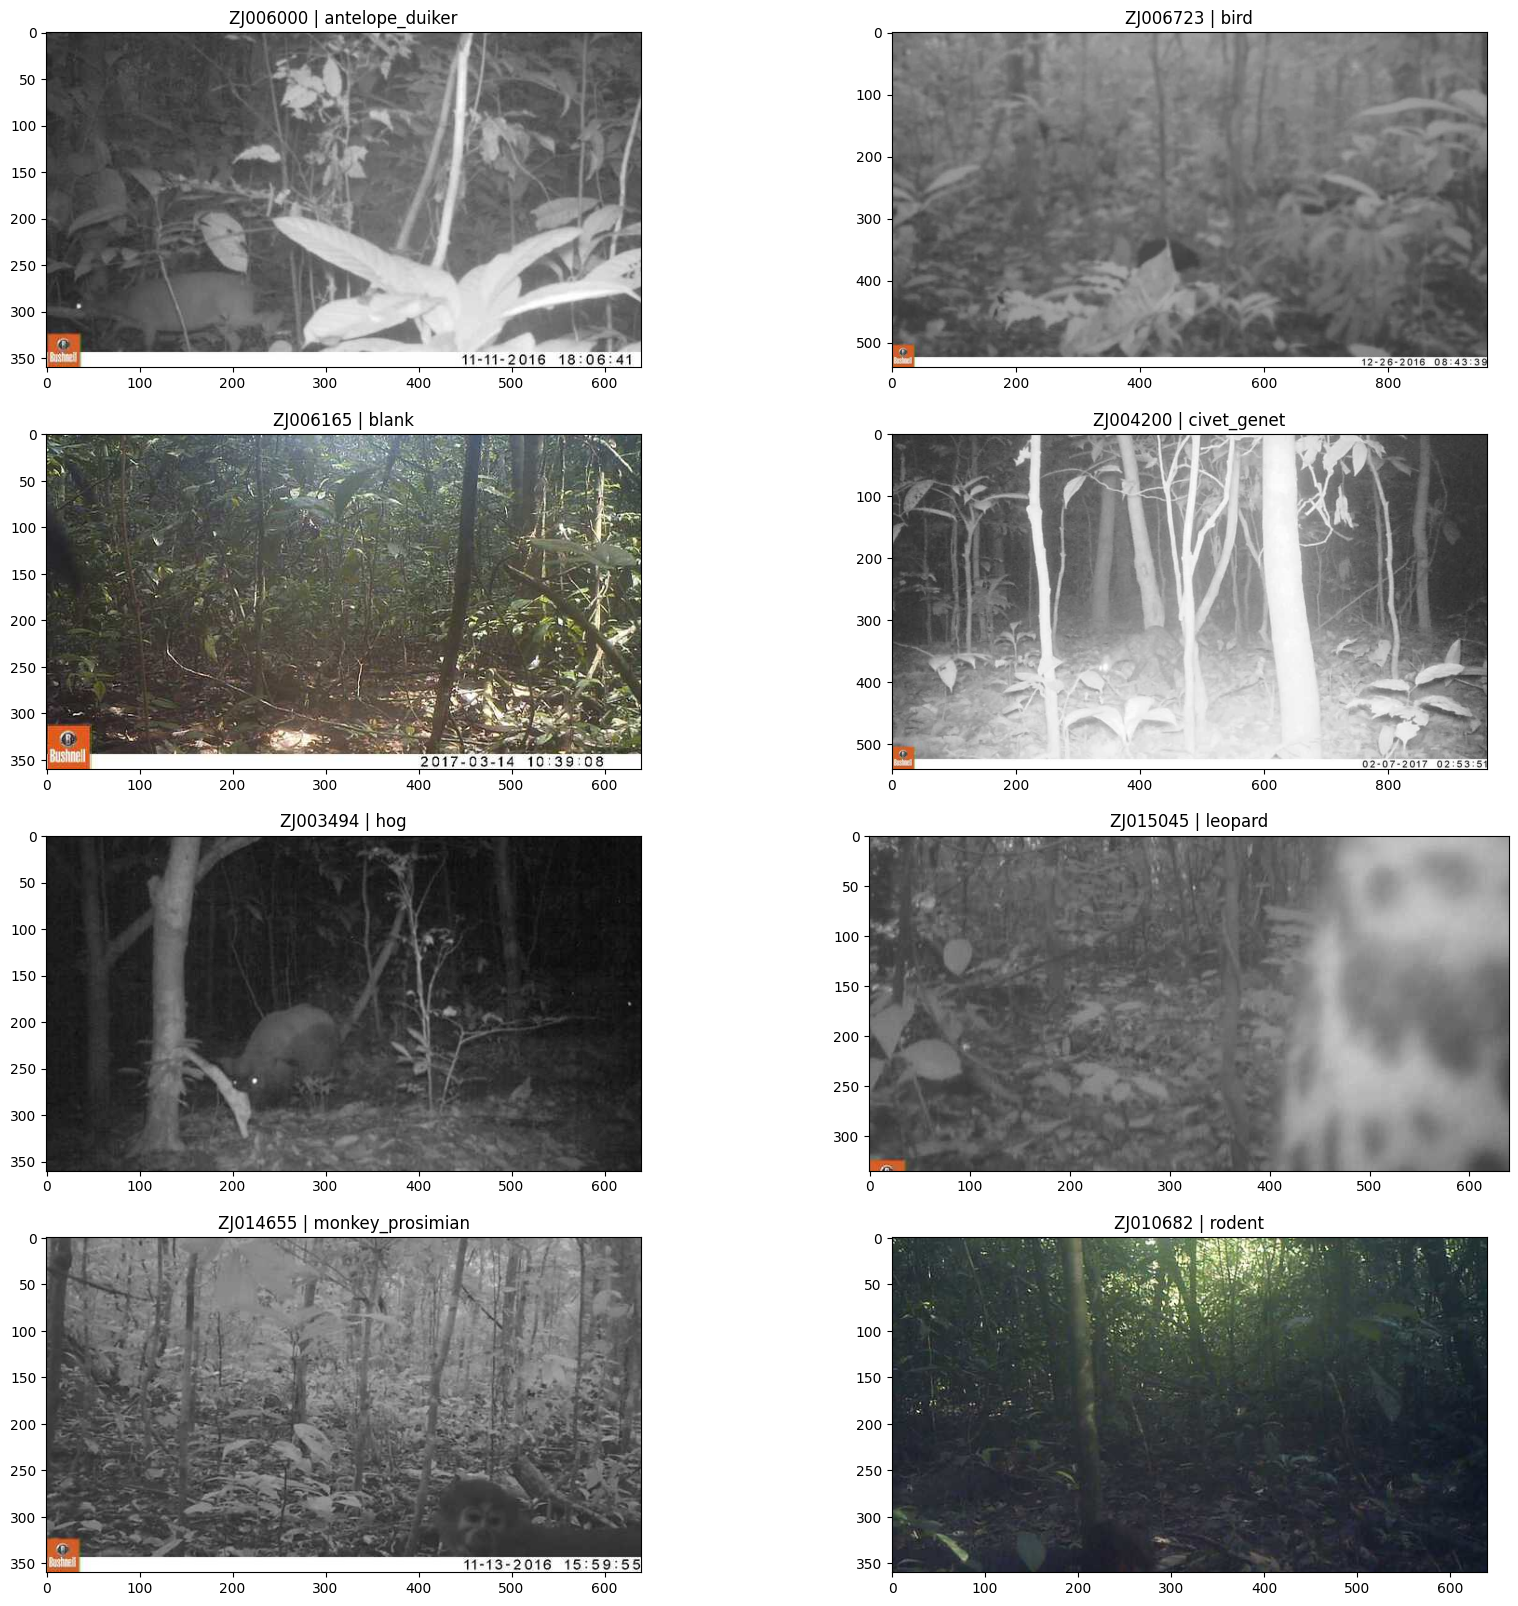

In [11]:
# we'll create a grid with 8 positions, one for each label (7 species, plus blanks)
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(20, 20))

# iterate through each species
for species, ax in zip(species_labels, axes.flat):
    # get an image ID for this species
    img_id = (
        train_labels[train_labels.loc[:,species] == 1]
        .sample(1, random_state=random_state)
        .index[0]
    )
    # reads the filepath and returns a numpy array
    img = mpimg.imread(train_features.loc[img_id].filepath)
    # plot etc
    ax.imshow(img, cmap='gray')
    ax.set_title(f"{img_id} | {species}")

Don't be too worried, if you cannot spot animals in some pictures. The combination of low-quality images and animals blending in well with their surroundings can make it tough to spot some animals.

Let's look at the distribution of species across the training set:

Absolute values:

In [12]:
train_labels.sum().sort_values(ascending=False)

monkey_prosimian    2492.0
antelope_duiker     2474.0
civet_genet         2423.0
leopard             2254.0
blank               2213.0
rodent              2013.0
bird                1641.0
hog                  978.0
dtype: float64

Percentage values:

In [13]:
train_labels.sum().divide(train_labels.shape[0]).sort_values(ascending=False)*100

monkey_prosimian    15.114022
antelope_duiker     15.004852
civet_genet         14.695536
leopard             13.670548
blank               13.421883
rodent              12.208879
bird                 9.952693
hog                  5.931587
dtype: float64

## Train-test-split

Here, we create the train-test-split and return the dimensions of the sets. We are always using the `stratify` option of `train_test_split` to make sure the percentages of the labels are equal in the test and train split.

In [14]:
y = train_labels.sample(frac=frac, random_state=random_state)
x = train_features.loc[y.index].filepath.to_frame()

# note that we are casting the species labels to an indicator/dummy matrix
x_train, x_eval, y_train, y_eval = train_test_split(
    x, y, stratify=y, test_size=test_size, random_state=random_state
)

x_train.shape, y_train.shape, x_eval.shape, y_eval.shape

((12366, 1), (12366, 8), (4122, 1), (4122, 8))

Here we create the `train_dataloader` and `eval_dataloader`

In [15]:
train_dataset = ImagesDataset(x_train, y_train, use_padding = use_padding, use_white_line_cropping = use_white_line_cropping, use_logo_cropping = use_logo_cropping, channels_number = channels_number)
train_dataloader = DataLoader(train_dataset, batch_size = batch_size)

In [16]:
eval_dataset = ImagesDataset(x_eval, y_eval, use_padding = use_padding, use_white_line_cropping = use_white_line_cropping, use_logo_cropping = use_logo_cropping, channels_number = channels_number)
eval_dataloader = DataLoader(eval_dataset, batch_size = batch_size)

Here is a random selection of images in the form they are entering the CNN:

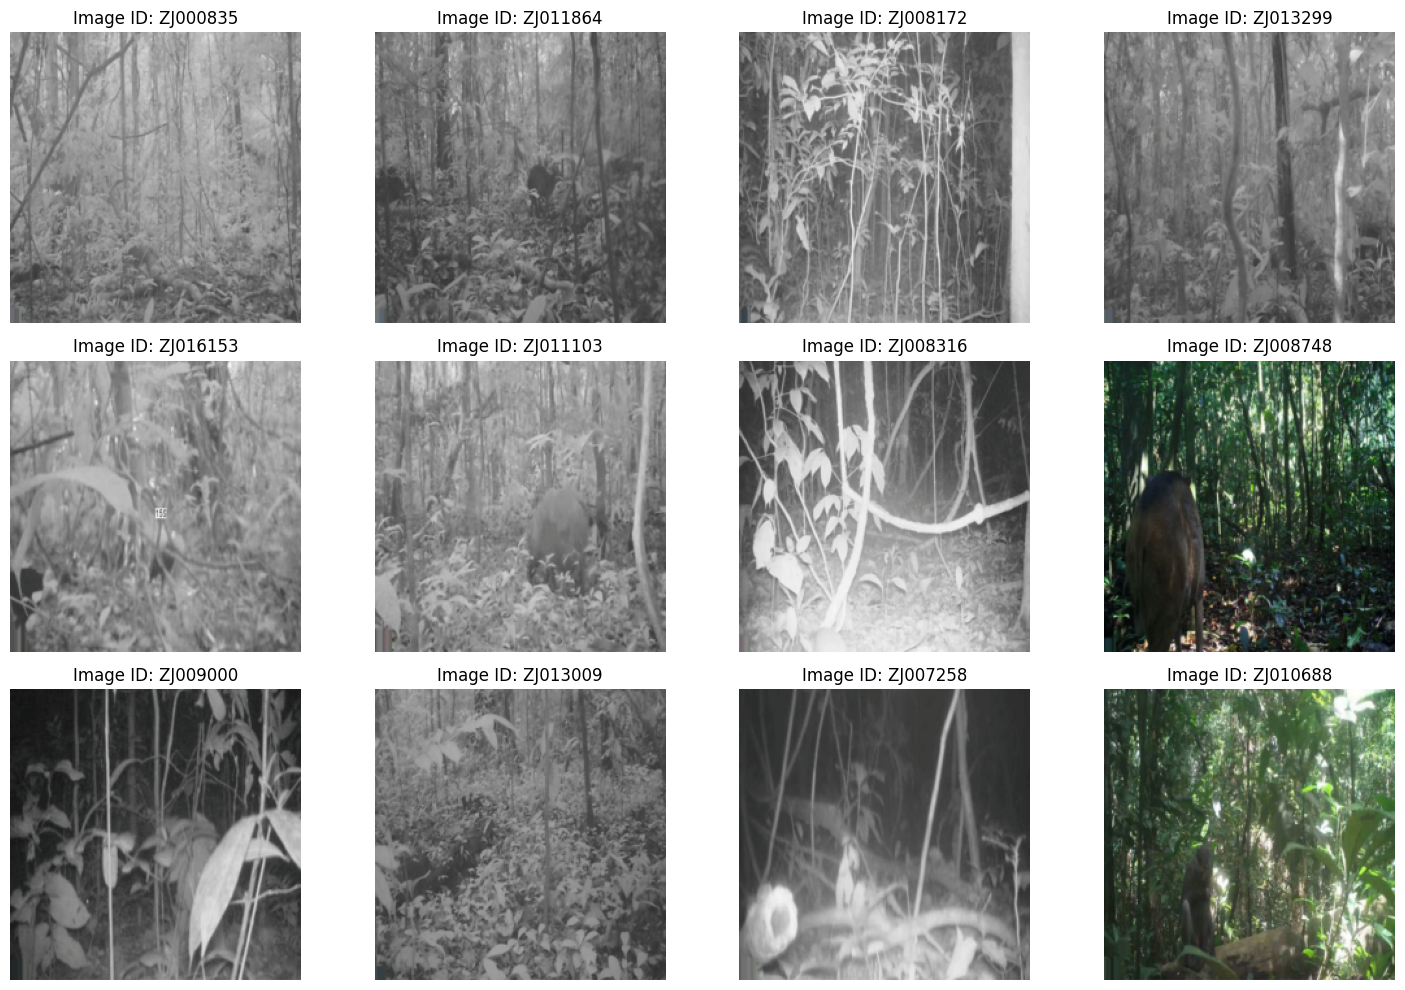

In [17]:
# Assuming `dataset` is an instance of ImagesDataset
display_random_images(eval_dataset)


### Define our loss function
Cross entropy loss (or log loss) is a commonly used loss function for multi-class (not multi-label) image classification. We'll use this to compute loss for each training batch and then update our parameters accordingly. 

# Training the model

In the next cell, we are training the model defined above. During training, we track the training and validation loss and return the numbers after each epoch as well as saving them in the variables `train_loss` and `val_loss`

In [18]:
train_loss = initial_train_loss
val_loss = initial_val_loss

# First let's make sure we only train a model if the correct mode is selected
if execute_mode > 0:
    model = loaded_model


else:

    num_epochs = epochs_number


    for epoch in range(1, num_epochs + 1):
        print(f"Starting epoch {epoch}")

        

        model.train()
        # iterate through the dataloader batches. tqdm keeps track of progress.
        for batch_n, batch in tqdm(
            enumerate(train_dataloader), total=len(train_dataloader)
        ):
            images = batch['image'].to(device)
            labels = batch['label'].to(device)
            
            # 1) zero out the parameter gradients so that gradients from previous batches are not used in this step
            optimizer.zero_grad()
            
            # 2) run the foward step on this batch of images
            outputs = model(images)

            # 3) compute the loss
            loss = criterion(outputs, labels)
            # let's keep track of the loss by epoch and batch
            train_loss[(epoch, batch_n)] = float(loss)

            # 4) compute our gradients
            loss.backward()
            # update our weights
            optimizer.step()
        
        model.eval()

        with torch.no_grad():
            for batch_n, batch in tqdm(enumerate(eval_dataloader), total=len(eval_dataloader)):
                eval_images = batch['image'].to(device)  # Move images to GPU
                eval_labels = batch['label'].to(device)  # Move labels to GPU

                # Run the forward step
                val_outputs = model(eval_images)
                
                # Compute the loss
                loss_v = criterion(val_outputs, eval_labels)
                # Keep track of the validation loss
                val_loss[(epoch, batch_n)] = float(loss_v)

        print(f"Epoch {epoch} - Train Loss: {loss:.5f}, Val Loss: {loss_v:.5f}")


Starting epoch 1


100%|██████████| 129/129 [00:49<00:00,  2.61it/s]


Epoch 1 - Train Loss: 0.73700, Val Loss: 0.80950
Starting epoch 2


100%|██████████| 129/129 [00:45<00:00,  2.81it/s]


Epoch 2 - Train Loss: 0.31460, Val Loss: 0.46163
Starting epoch 3


100%|██████████| 129/129 [00:45<00:00,  2.81it/s]


Epoch 3 - Train Loss: 0.02024, Val Loss: 0.55237
Starting epoch 4


100%|██████████| 129/129 [00:46<00:00,  2.78it/s]


Epoch 4 - Train Loss: 0.00444, Val Loss: 0.75322
Starting epoch 5


100%|██████████| 129/129 [00:45<00:00,  2.84it/s]


Epoch 5 - Train Loss: 0.00495, Val Loss: 0.65208
Starting epoch 6


100%|██████████| 129/129 [00:45<00:00,  2.82it/s]


Epoch 6 - Train Loss: 0.00838, Val Loss: 0.88060
Starting epoch 7


100%|██████████| 129/129 [00:45<00:00,  2.82it/s]


Epoch 7 - Train Loss: 0.00222, Val Loss: 0.91121
Starting epoch 8


100%|██████████| 129/129 [00:48<00:00,  2.66it/s]


Epoch 8 - Train Loss: 0.00473, Val Loss: 1.06745
Starting epoch 9


100%|██████████| 129/129 [00:47<00:00,  2.69it/s]


Epoch 9 - Train Loss: 0.00432, Val Loss: 1.04950
Starting epoch 10


100%|██████████| 129/129 [00:46<00:00,  2.80it/s]

Epoch 10 - Train Loss: 0.00889, Val Loss: 1.42612


From now on, we don't need the GPU anymore and everything else is better computed on the CPU. Hence, we move everything back to the CPU:

In [19]:
if execute_mode == 0:

    model.cpu()
    images = images.cpu()
    labels = labels.cpu()

    torch.cuda.empty_cache()

Now let's plot the loss by epoch and batch. The x-axis here is a tuple of `(epoch, batch)`.

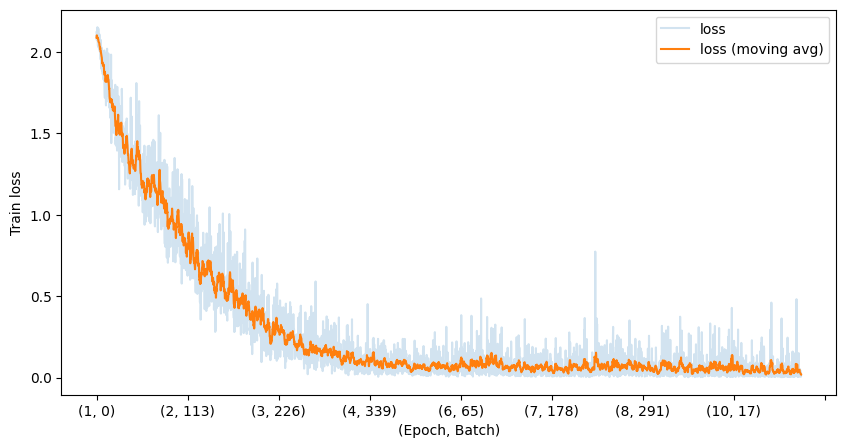

In [20]:
train_loss = pd.Series(train_loss)
if len(train_loss) == 0:
    print('No train_loss data for saved model')
else:
    plt.figure(figsize=(10, 5))
    train_loss.plot(alpha=0.2, label="loss")
    train_loss.rolling(center=True, min_periods=1, window=10).mean().plot(
        label="loss (moving avg)"
    )
    plt.xlabel("(Epoch, Batch)")
    plt.ylabel("Train loss")
    plt.legend(loc=0)

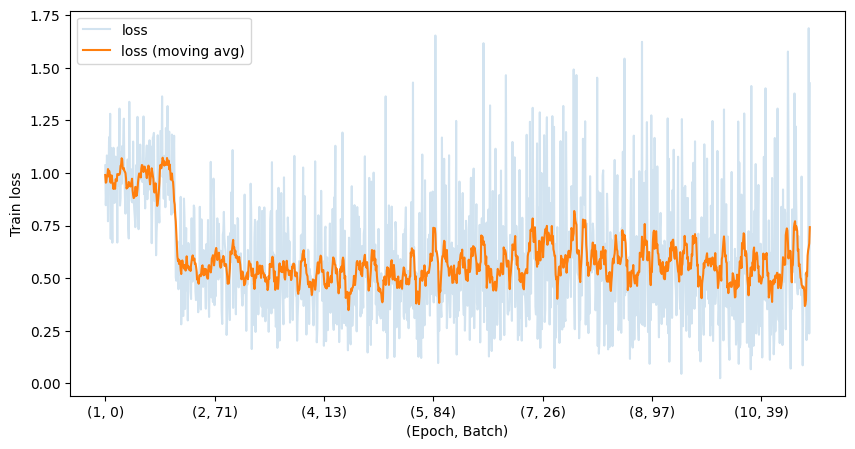

In [21]:
val_loss = pd.Series(val_loss)
if len(val_loss) == 0:
    print('No val_loss data for saved model')
else:
    plt.figure(figsize=(10, 5))
    val_loss.plot(alpha=0.2, label="loss")
    val_loss.rolling(center=True, min_periods=1, window=10).mean().plot(
        label="loss (moving avg)"
    )
    plt.xlabel("(Epoch, Batch)")
    plt.ylabel("Train loss")
    plt.legend(loc=0)

### Save the model

In [22]:
if execute_mode == 0:
    torch.save(model, os.path.join(model_folder, 'model.pth'))
    train_loss.to_csv(os.path.join(model_folder, 'train_loss.csv'))
    val_loss.to_csv(os.path.join(model_folder, 'val_loss.csv'))

# Make predictions

We either load the prediction we have saved before, or we use the (loaded) model to make a prediction of the labels fo the validation set. The latter would return and save a dataframe of the softmax layer output per image in the validation set.

In [23]:
if execute_mode == 2:
    eval_preds_df = initial_eval_preds_df

else:
    eval_preds_df = make_predictions(eval_dataloader,model,species_labels)
    eval_preds_df.to_csv(os.path.join(model_folder, 'eval_preds_df.csv'), index_label='id')

eval_preds_df

100%|██████████| 129/129 [00:43<00:00,  2.96it/s]


antelope_duiker          bird         blank   civet_genet   
ZJ000013     1.557190e-05  1.651855e-07  9.999624e-01  4.047452e-07  \
ZJ000016     4.301411e-05  1.395319e-02  2.415236e-02  4.705448e-05   
ZJ000018     1.025572e-02  1.574202e-02  9.520426e-01  1.999040e-04   
ZJ000022     9.999679e-01  7.036631e-07  9.359646e-06  7.319333e-07   
ZJ000025     2.029368e-07  2.484830e-06  5.476608e-05  1.111948e-06   
...                   ...           ...           ...           ...   
ZJ016473     4.213071e-06  2.317392e-09  9.436966e-07  9.999930e-01   
ZJ016479     9.804466e-06  9.998477e-01  1.936072e-05  2.836094e-07   
ZJ016483     5.839287e-05  5.540768e-06  6.839669e-01  1.082512e-05   
ZJ016485     1.004300e-04  2.768696e-08  1.622407e-03  9.981871e-01   
ZJ016487     6.409126e-08  4.748434e-09  9.330237e-07  9.999924e-01   

                   hog       leopard  monkey_prosimian        rodent  
ZJ000013  8.305908e-07  4.616341e-06      1.238374e-05  3.492705e-06  
ZJ000016  3.051563e-03  9.559247e-01      2.746025e-03  8.203481e-05  
ZJ000018  8.028559e-04  3.016907e-03      1.569329e-02  2.246712e-03  
ZJ000022  2.070451e-05  2.899191e-09      4.212296e-07  1.488162e-07  
ZJ000025  2.279960e-08  2.806281e-07      8.387659e-10  9.999412e-01  
...                ...           ...               ...           ...  
ZJ016473  1.042696e-07  6.539778e-08      1.282772e-08  1.653291e-06  
ZJ016479  1.123581e-05  5.052972e-05      9.929020e-06  5.120913e-05  
ZJ016483  8.492368e-07  1.327223e-05      4.103046e-06  3.159401e-01  
ZJ016485  2.652736e-05  1.034918e-05      9.242824e-08  5.306597e-05  
ZJ016487  8.869204e-07  3.840640e-06      9.585845e-09  1.949286e-06  

[4122 rows x 8 columns]

In [24]:
eval_preds_df.to_csv(os.path.join(model_folder, 'eval_preds_df.csv'), index_label='id')
eval_preds_df

antelope_duiker          bird         blank   civet_genet   
ZJ000013     1.557190e-05  1.651855e-07  9.999624e-01  4.047452e-07  \
ZJ000016     4.301411e-05  1.395319e-02  2.415236e-02  4.705448e-05   
ZJ000018     1.025572e-02  1.574202e-02  9.520426e-01  1.999040e-04   
ZJ000022     9.999679e-01  7.036631e-07  9.359646e-06  7.319333e-07   
ZJ000025     2.029368e-07  2.484830e-06  5.476608e-05  1.111948e-06   
...                   ...           ...           ...           ...   
ZJ016473     4.213071e-06  2.317392e-09  9.436966e-07  9.999930e-01   
ZJ016479     9.804466e-06  9.998477e-01  1.936072e-05  2.836094e-07   
ZJ016483     5.839287e-05  5.540768e-06  6.839669e-01  1.082512e-05   
ZJ016485     1.004300e-04  2.768696e-08  1.622407e-03  9.981871e-01   
ZJ016487     6.409126e-08  4.748434e-09  9.330237e-07  9.999924e-01   

                   hog       leopard  monkey_prosimian        rodent  
ZJ000013  8.305908e-07  4.616341e-06      1.238374e-05  3.492705e-06  
ZJ000016  3.051563e-03  9.559247e-01      2.746025e-03  8.203481e-05  
ZJ000018  8.028559e-04  3.016907e-03      1.569329e-02  2.246712e-03  
ZJ000022  2.070451e-05  2.899191e-09      4.212296e-07  1.488162e-07  
ZJ000025  2.279960e-08  2.806281e-07      8.387659e-10  9.999412e-01  
...                ...           ...               ...           ...  
ZJ016473  1.042696e-07  6.539778e-08      1.282772e-08  1.653291e-06  
ZJ016479  1.123581e-05  5.052972e-05      9.929020e-06  5.120913e-05  
ZJ016483  8.492368e-07  1.327223e-05      4.103046e-06  3.159401e-01  
ZJ016485  2.652736e-05  1.034918e-05      9.242824e-08  5.306597e-05  
ZJ016487  8.869204e-07  3.840640e-06      9.585845e-09  1.949286e-06  

[4122 rows x 8 columns]

# Evaluate

### Predicted labels distribution
First let's compare the distributions of labels as predicted by our model with the true distributions of the validation and test set:

In [25]:
# Prepare predicted label count
eval_preds_df_counts = eval_preds_df.idxmax(axis=1).value_counts()
eval_preds_df_counts_percent = eval_preds_df_counts / eval_preds_df_counts.sum()

# Prepare true label count for validation set
y_eval_counts = y_eval.idxmax(axis=1).value_counts()
y_eval_counts_percent = y_eval_counts / y_eval_counts.sum()

# Prepare true label count for training set
y_train_counts = y_train.idxmax(axis=1).value_counts()
y_train_counts_percent = y_train_counts/y_train_counts.sum()

# Concat all into a dataframe and print the dataframe
pred_df = pd.concat([eval_preds_df_counts, eval_preds_df_counts_percent, y_eval_counts, y_eval_counts_percent, y_train_counts, y_train_counts_percent], axis = 1)
pred_df.columns = ['Pred labels (count)', 'Pred labels (relative)', 'True val labels (count)', 'True val labels (relative)', 'True train labels (count)', 'True train labels (relative)']

pred_df

Pred labels (count)  Pred labels (relative)   
civet_genet                       638                0.154779  \
monkey_prosimian                  607                0.147259   
blank                             594                0.144105   
antelope_duiker                   544                0.131975   
leopard                           543                0.131732   
rodent                            531                0.128821   
bird                              422                0.102377   
hog                               243                0.058952   

                  True val labels (count)  True val labels (relative)   
civet_genet                           606                    0.147016  \
monkey_prosimian                      623                    0.151140   
blank                                 553                    0.134158   
antelope_duiker                       619                    0.150170   
leopard                               564                    0.136827   
rodent                                503                    0.122028   
bird                                  410                    0.099466   
hog                                   244                    0.059195   

                  True train labels (count)  True train labels (relative)  
civet_genet                            1817                      0.146935  
monkey_prosimian                       1869                      0.151140  
blank                                  1660                      0.134239  
antelope_duiker                        1855                      0.150008  
leopard                                1690                      0.136665  
rodent                                 1510                      0.122109  
bird                                   1231                      0.099547  
hog                                     734                      0.059356

### Accuracy
Now let's compute how accurate our model is. First let's get the labels with the highest score for each image.

In [26]:
eval_predictions = eval_preds_df.idxmax(axis=1).sort_index()
eval_predictions.head()

ZJ000013              blank
ZJ000016            leopard
ZJ000018              blank
ZJ000022    antelope_duiker
ZJ000025             rodent
dtype: object

In [27]:
eval_true = y_eval.idxmax(axis=1).sort_index()
eval_true.head()

id
ZJ000013              blank
ZJ000016            leopard
ZJ000018              blank
ZJ000022    antelope_duiker
ZJ000025             rodent
dtype: object

Random guessing across 8 classes would yield an accuracy of 12.5% (1/8). Let's see how our model compares. We take the species with the highest score for each image (`eval_predictions`) and compare that to the true labels.

In [28]:
correct = (eval_predictions == eval_true).sum()
accuracy = correct / len(eval_predictions)

print('Accuracy Score:')
print(round(accuracy, 5))

Accuracy Score:
0.86948


### Confusion Matrix

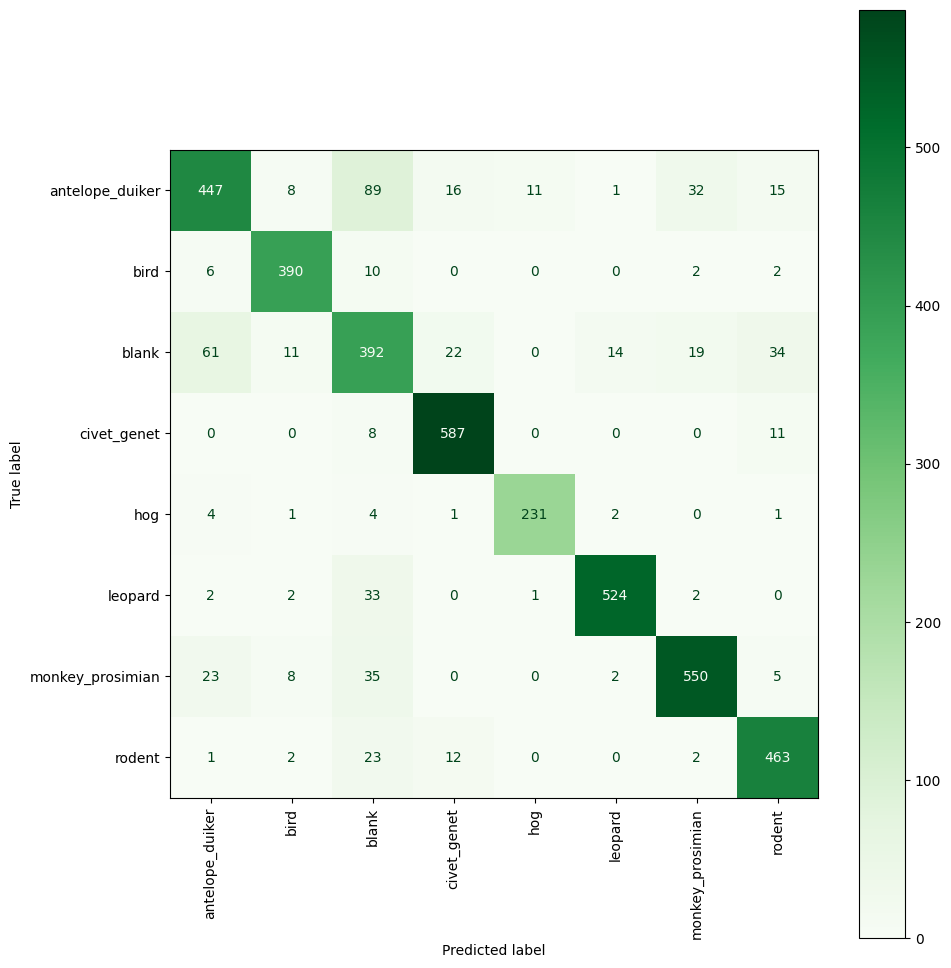

In [29]:
from sklearn.metrics import ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(10, 10), tight_layout=True)
cm = ConfusionMatrixDisplay.from_predictions(
    eval_true,
    eval_predictions,
    ax=ax,
    xticks_rotation=90,
    colorbar=True,
    cmap = plt.cm.Greens
)

In [30]:
fig.savefig(model_folder + 'confmatrix.png', dpi = 600, transparent=True)

## Error analysis

### Save errors in the folder errors/pictures to analyze them

In [31]:

# Define the path for the error directory
errors_directory = os.path.join(data_folder, 'errors')
csv_file_path = os.path.join(errors_directory, 'error_df.csv')
if os.path.exists(csv_file_path):
    error_df = pd.read_csv(csv_file_path)
def recreate_directory(directory):
    """Delete the directory if it exists and recreate it."""
    if os.path.exists(directory):
        shutil.rmtree(directory)  # Remove the directory and all its contents
    os.makedirs(directory)  # Create a new empty directory
# Define the path for the pictures directory
pictures_directory = os.path.join(errors_directory, 'pictures')
# Recreate the directory
recreate_directory(pictures_directory)
# Loop through the rows of the error_df DataFrame
for idx, row in error_df.iterrows():
    original_filepath = row['filepath']
    # Create new filename using the format 'id_real_predict.jpg'
    new_filename = f"{idx}__{row['real']}__{row['predict']}.jpg"
    new_filepath = os.path.join(pictures_directory, new_filename)
    # Rename the image file and copy to error folder
    shutil.copy(original_filepath, new_filepath)

### Display misclassified images

Executing the second cell multiple times will load and display the next set of images

In [32]:
# Initialize the counter
counter = 0

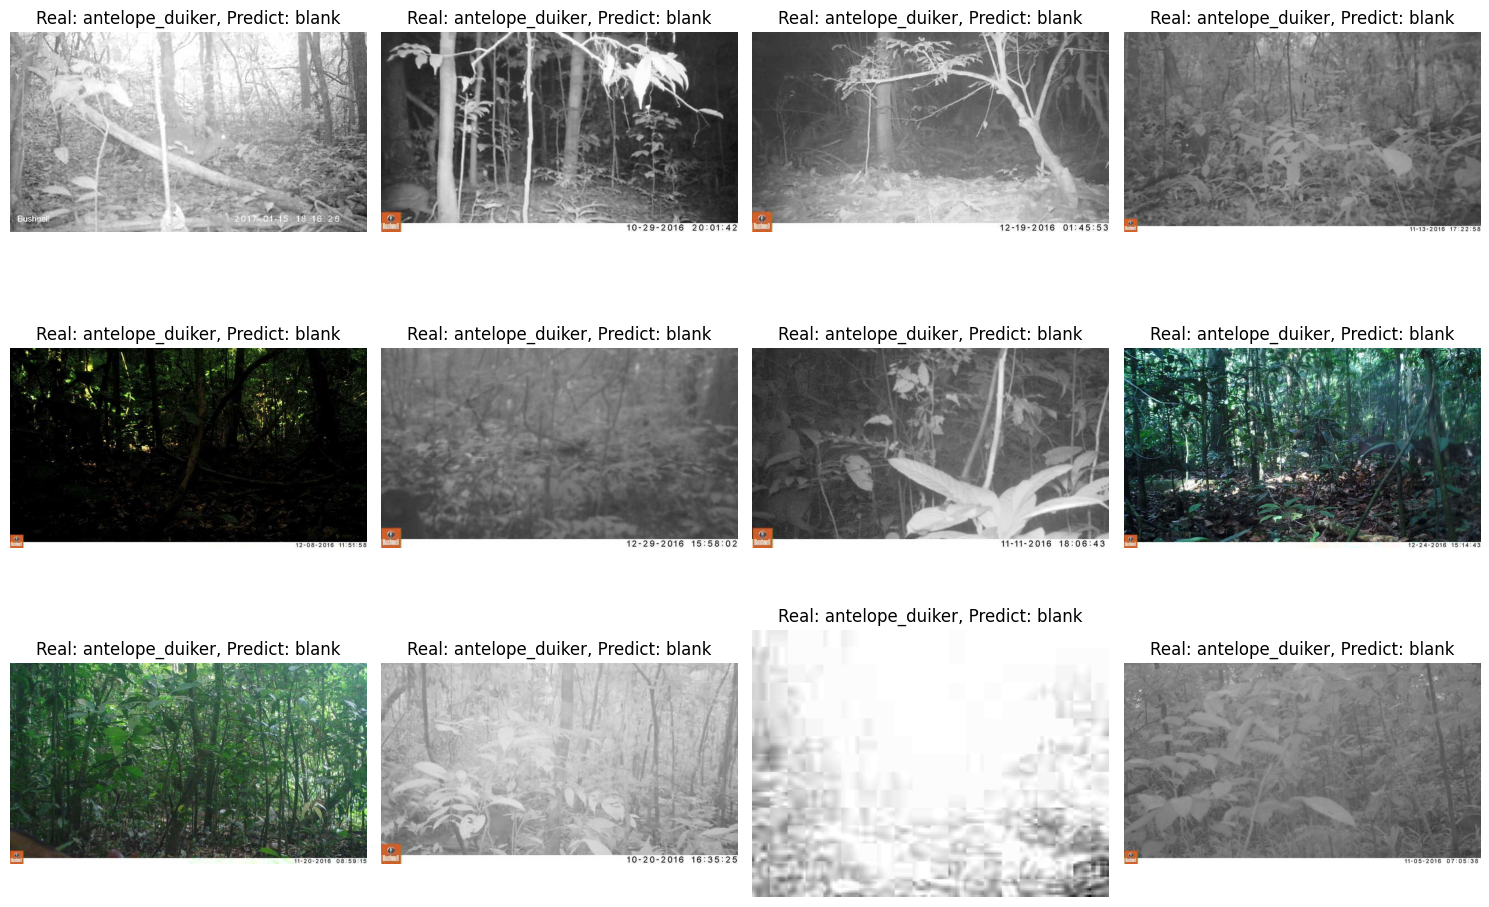

In [33]:


def display_images(error_df, counter, batch_size=12):
    # Define the range of indices to display
    start_idx = counter
    end_idx = min(counter + batch_size, len(error_df))
    # Slice the DataFrame to get the current batch
    batch_df = error_df.iloc[start_idx:end_idx]
    # Display images
    plt.figure(figsize=(15, 10))
    for i, (idx, row) in enumerate(batch_df.iterrows()):
        image = Image.open(row['filepath'])
        plt.subplot(3, 4, i + 1)
        plt.imshow(image, cmap='gray')
        plt.title(f"Real: {row['real']}, Predict: {row['predict']}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()
# Update the counter for the next batch
counter += 12
# Display the current batch of images
display_images(error_df, counter)

### Create a dataframe with top 3 predictions per image 

The function needs a dataframe with probabilities as input

In [34]:
top_3_df = top_3_predictions_with_labels(eval_preds_df)
top_3_df.head(20)

top1          top2          top3       top1_label        top2_label   
ZJ003344   1.0  3.288943e-09  1.505860e-09      civet_genet            rodent  \
ZJ010780   1.0  2.931442e-08  2.844971e-08      civet_genet           leopard   
ZJ008543   1.0  1.360143e-08  6.057085e-09             bird           leopard   
ZJ000288   1.0  8.577896e-08  2.502860e-08           rodent             blank   
ZJ015283   1.0  1.006379e-07  1.944032e-08           rodent             blank   
ZJ015400   1.0  5.280980e-08  3.161270e-08      civet_genet             blank   
ZJ006835   1.0  1.363066e-07  3.279629e-08      civet_genet            rodent   
ZJ007500   1.0  1.142462e-07  5.170142e-08      civet_genet   antelope_duiker   
ZJ007551   1.0  5.131317e-08  1.093757e-08      civet_genet   antelope_duiker   
ZJ016291   1.0  2.033590e-07  2.330667e-08      civet_genet            rodent   
ZJ011579   1.0  6.963863e-08  6.772278e-08      civet_genet            rodent   
ZJ008666   1.0  1.262047e-07  5.872858e-08             bird            rodent   
ZJ002920   1.0  1.159412e-07  8.361658e-08          leopard       civet_genet   
ZJ003780   1.0  2.128233e-07  2.328344e-08      civet_genet            rodent   
ZJ006951   1.0  1.450655e-07  6.866105e-08             bird           leopard   
ZJ001409   1.0  1.012699e-07  6.729066e-08          leopard             blank   
ZJ014434   1.0  3.879925e-07  1.277478e-08  antelope_duiker  monkey_prosimian   
ZJ004216   1.0  2.174760e-07  1.289705e-07      civet_genet           leopard   
ZJ006083   1.0  2.547552e-07  7.540294e-08           rodent       civet_genet   
ZJ014246   1.0  9.512718e-08  7.255787e-08      civet_genet             blank   

               top3_label  
ZJ003344            blank  
ZJ010780  antelope_duiker  
ZJ008543              hog  
ZJ000288      civet_genet  
ZJ015283      civet_genet  
ZJ015400           rodent  
ZJ006835            blank  
ZJ007500           rodent  
ZJ007551              hog  
ZJ016291            blank  
ZJ011579            blank  
ZJ008666  antelope_duiker  
ZJ002920            blank  
ZJ003780            blank  
ZJ006951           rodent  
ZJ001409      civet_genet  
ZJ014434            blank  
ZJ004216            blank  
ZJ006083            blank  
ZJ014246          leopard

# (Optional) Create submission

Last but not least, we'll want to participate in the competition and see where we stand on the leaderboard.

To do this we need to create predictions for the **competition test set** (not the eval set we used above). We don't have labels for these.

We'll create predictions in the same way we did for the `eval` set, but this time using the `test_features` we downloaded from the [competition website](https://www.drivendata.org/competitions/87/competition-image-classification-wildlife-conservation/data/).

In [35]:
if create_submission:
    test_dataset = ImagesDataset(test_features.filepath.to_frame(), use_padding=use_padding, use_white_line_cropping=use_white_line_cropping, use_logo_cropping=use_logo_cropping, channels_number=channels_number)
    test_dataloader = DataLoader(test_dataset, batch_size=32)

    if execute_mode == 2:
        submission_df = initial_submission_df


    else:
        submission_df = make_predictions(test_dataloader,model,species_labels)
        submission_df.to_csv(os.path.join(model_folder, 'submission_df.csv'), index_label='id')


    submission_df
else:
    print('create_submission set to False')

100%|██████████| 140/140 [00:54<00:00,  2.57it/s]


Let's check a couple things on `submission_df` before submitting to the platform. We'll want to make sure our submission's index and column labels match the submission format. (The DrivenData platform will do these data integrity checks as well, but it will be quicker to detect problems this way.)

In [36]:
if create_submission:
    submission_format = pd.read_csv("../data/submission_format.csv", index_col="id")

    assert all(submission_df.index == submission_format.index)
    assert all(submission_df.columns == submission_format.columns)

Looks like we're ready to submit! Save the dataframe out to a CSV file and then upload it via the [Submissions page](https://www.drivendata.org/competitions/87/competition-image-classification-wildlife-conservation/submissions/) on the competition website.